# Recombination & Retrival for Servoing

This notebook shows an example of how a suitable demonstration can be selected if several candidates are avaliable. The current selection is based on reprojection error.

Instructions:

    1. Record and Segment Demonstrations using `Record_and_Segment.ipynb`


## 1. Load Existing Demonstrations

In [1]:
import os
import copy
import json
import logging
from glob import glob
from pathlib import Path

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, Layout

from flow_control.demo.playback_env_servo import PlaybackEnvServo

root_dir = "/tmp/flow_experiments3"
task = "shape_sorting"
object_selected = "trapeze" 
task_variant = "rP"  # rotation plus (+-pi)

def get_configurations(root_dir=root_dir, num_episodes=40, prefix=""):
    os.makedirs(root_dir, exist_ok=True)
    save_dir_template = os.path.join(root_dir, f"{prefix}_{task}_{object_selected}")
    for seed in range(num_episodes):
        save_dir = save_dir_template + f"_{task_variant}"+f"_seed{seed:03d}"
        yield object_selected, seed, save_dir
            
demo_cfgs = get_configurations(prefix="demo")
recordings = []
for _, demo_seed, demo_dir in demo_cfgs:
    recordings.append(demo_dir)
    
print("Number of recordings:", len(recordings))
print("first", recordings[0])
print("last ", recordings[-1])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Number of recordings: 40
first /tmp/flow_experiments3/demo_shape_sorting_trapeze_rP_seed000
last  /tmp/flow_experiments3/demo_shape_sorting_trapeze_rP_seed039


In [2]:
# Load the demonstration episodes
playbacks = [PlaybackEnvServo(rec) for rec in recordings[:]]

# If you get Warnings: Couldn't find servoing keyframes, you need to segment the demos
# This is shown in Record_and_Segment.ipynb 

<IPython.core.display.Javascript object>


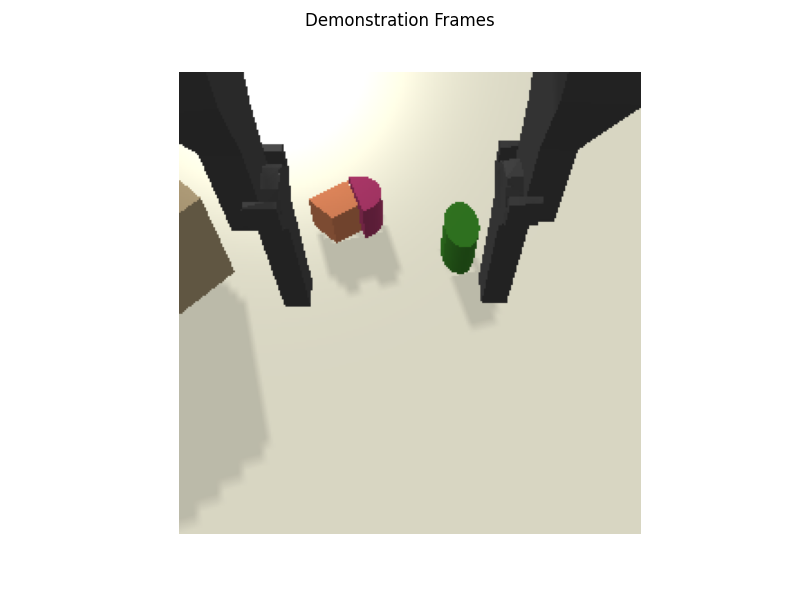

interactive(children=(IntSlider(value=0, description='demo_index', layout=Layout(width='70%'), max=39), IntSli…

<function __main__.update(demo_index, frame_index)>

In [3]:
# Plot the demonstrations
%matplotlib notebook
fig, ax = plt.subplots(1,figsize=(8, 6))
fig.suptitle("Demonstration Frames")
ax.set_axis_off()
image_h = ax.imshow(playbacks[0].cam.get_image()[0])

def update(demo_index, frame_index):
    image = playbacks[demo_index][frame_index].cam.get_image()[0]
    image_h.set_data(image)
    fig.canvas.draw_idle()
    print("wp_name:", playbacks[demo_index][frame_index].get_info()["wp_name"])
    print("keep:", playbacks[demo_index].keep_dict.keys())
    fg_mask = playbacks[demo_index].get_fg_mask()
    if fg_mask is not None:
        print(f"percent fg @ {demo_index}, 0:", round(np.mean(fg_mask)*100,2))
    
slider_w = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=0,
                             layout=Layout(width='70%'))
slider_i = widgets.IntSlider(min=0, max=200-1, step=1, value=0,
                             layout=Layout(width='70%'))

interact(update, demo_index=slider_w, frame_index=slider_i)

# Filter Bad Demonstrations

In [16]:
# Summarize the demonstration info
def filter_demo(pb):
    return pb[-1].data['rew'] > 0 and np.mean(pb.get_fg_mask()) > 0.005

demo_good = [filter_demo(pb) for pb in playbacks]

# print summary
fg_pixels = [np.mean(pb.get_fg_mask())*100 for pb in playbacks]
header = "ep\t len\t rew\t fg[%] bad"
print(header,"\n"+"-"*len(header.replace("\t"," "*5)))
for i, pb in enumerate(playbacks):
    print(i, "\t", len(pb), "\t", pb[-1].data["rew"],"\t", round(fg_pixels[i], 2),"\tx" if not demo_good[i] else '')    
print()

bad_pair_arr = np.zeros((len(playbacks), len(playbacks)), dtype=bool)
for idx in np.where(np.array(demo_good) == False)[0]:
    bad_pair_arr[:,idx] = True
    bad_pair_arr[idx,:] = True
bad_pair_arr += np.eye(len(playbacks), len(playbacks), dtype=bool)
#print(bad_pairs.astype(int))
good_pairs = list(zip(*np.where(bad_pair_arr==False)))

print(f"Good demos:   {np.mean(demo_good)*100:.1f} %\t", sum(demo_good),"/",len(demo_good) )
print(f"Viable pairs: {(1-bad_pair_arr.mean())*100:.1f} %\t",sum(bad_pair_arr.flatten()==0),"/", bad_pair_arr.size)



ep	 len	 rew	 fg[%] bad 
-----------------------------------
0 	 48 	 1.0 	 1.02 
1 	 200 	 0.0 	 1.12 	x
2 	 48 	 1.0 	 0.43 	x
3 	 46 	 1.0 	 1.12 
4 	 48 	 1.0 	 1.08 
5 	 49 	 1.0 	 0.71 
6 	 46 	 1.0 	 1.05 
7 	 46 	 1.0 	 0.58 
8 	 47 	 1.0 	 1.09 
9 	 46 	 1.0 	 0.77 
10 	 46 	 1.0 	 1.17 
11 	 46 	 1.0 	 1.19 
12 	 48 	 1.0 	 1.02 
13 	 47 	 1.0 	 0.92 
14 	 48 	 1.0 	 1.13 
15 	 48 	 1.0 	 1.1 
16 	 49 	 1.0 	 1.22 
17 	 49 	 1.0 	 1.12 
18 	 48 	 1.0 	 1.0 
19 	 49 	 1.0 	 1.15 
20 	 47 	 1.0 	 1.09 
21 	 47 	 1.0 	 1.07 
22 	 47 	 1.0 	 1.21 
23 	 47 	 1.0 	 0.91 
24 	 46 	 1.0 	 1.26 
25 	 46 	 1.0 	 0.6 
26 	 200 	 0.0 	 1.11 	x
27 	 46 	 1.0 	 1.37 
28 	 47 	 1.0 	 1.15 
29 	 48 	 1.0 	 1.05 
30 	 200 	 0.0 	 0.84 	x
31 	 47 	 1.0 	 1.31 
32 	 48 	 1.0 	 1.05 
33 	 47 	 1.0 	 1.1 
34 	 49 	 1.0 	 1.19 
35 	 46 	 1.0 	 1.15 
36 	 48 	 1.0 	 1.2 
37 	 48 	 1.0 	 1.06 
38 	 48 	 1.0 	 1.09 

Good demos:   89.7 %	 35 / 39
Viable pairs: 78.2 %	 1190 / 1521


## Compute Similarity for Viable Pairs

Given the set of viable pairs, compute how similar the inital frames are.

In [12]:
playbacks.pop(34)

In [17]:
from r3m import load_r3m
import torchvision.transforms as T
import torch
import ipdb

transform = T.Compose([T.ToTensor()])

def get_r3m_embeddings(playbacks, transform=None, device='cuda', masked=False):
    embeddings = []

    r3m = load_r3m("resnet50")
    r3m.eval()
    r3m.to(device)
    
    with torch.no_grad():
        
        for pb in playbacks:
            im = pb[0].cam.get_image()[0]
            
            if masked:
                mask = pb.get_fg_mask()
                mask = mask[..., np.newaxis].repeat(3, axis=2)
                im = im * mask
                
            im = transform(im)

            im = im.unsqueeze(0).cuda()
            embeddings.append(r3m(im * 255.0))
        
        embeddings = torch.cat(embeddings)
    
    embeddings = embeddings.detach().cpu().numpy()
    
    return embeddings

embeddings_with_mask = get_r3m_embeddings(playbacks, transform=transform, device='cuda', masked=True)
embeddings_without_mask = get_r3m_embeddings(playbacks, transform=transform, device='cuda', masked=False)

In [18]:
from scipy.spatial import distance

sim_scores = np.ones(bad_pair_arr.shape) * 10.0  # lower is better

for live_i, demo_i in tqdm(good_pairs):
    live_embedding = embeddings_without_mask[live_i, :] 
    
    demo_embedding = embeddings_with_mask[demo_i, :]
#     error = 1 - distance.cosine(demo_embedding, live_embedding)
    error = np.linalg.norm(demo_embedding - live_embedding)
#     assert error <= 1.0
    sim_scores[demo_i, live_i] = error

100%|███████████████████████████████████████████████████████████████████████████████████| 1190/1190 [00:00<00:00, 124292.70it/s]


In [19]:
sim_scores

array([[10.        , 10.        , 10.        , ...,  4.12847614,
         4.2667141 ,  4.38928509],
       [10.        , 10.        , 10.        , ..., 10.        ,
        10.        , 10.        ],
       [10.        , 10.        , 10.        , ..., 10.        ,
        10.        , 10.        ],
       ...,
       [ 4.1206665 , 10.        , 10.        , ..., 10.        ,
         4.29820728,  4.4143343 ],
       [ 4.11088896, 10.        , 10.        , ...,  4.15786886,
        10.        ,  4.41928911],
       [ 4.07942581, 10.        , 10.        , ...,  4.12388897,
         4.26045513, 10.        ]])

In [ ]:
from torchsummary import summary
import torch.nn as nn

r3m = load_r3m("resnet50")
r3m.eval()
r3m.cuda()

# Update network
r3m = r3m.module
convnet = r3m.convnet

arch = list(convnet.children())

del arch[-2]  # AvgPool
del arch[-1]  # FC

convnet = nn.Sequential(*arch)
r3m.convnet = convnet

r3m = nn.DataParallel(r3m)
summary(r3m, (3, 256, 256))

In [ ]:
import ipdb

def get_r3m_features(playbacks, transform=None, masked=False):
    embeddings = []
    features = []
    max_locations = []
    
    r3m = load_r3m("resnet50")
    r3m.cuda()
    
    # Update network
    r3m = r3m.module
    convnet = r3m.convnet

    arch = list(convnet.children())

    del arch[-2]  # AvgPool
    del arch[-1]  # FC

    convnet = nn.Sequential(*arch)
    r3m.convnet = convnet

    r3m = nn.DataParallel(r3m)
    r3m.eval()
    
    with torch.no_grad():
        
        for pb in playbacks:
            im = pb[0].cam.get_image()[0]
            
            if masked:
                mask = pb.get_fg_mask()
                mask = np.array(mask, dtype=float)
                
                tmp_mask = resize(mask, (8,8))
                tmp_mask = np.asarray(Image.fromarray(mask).resize((8,8)))
                
                max_x, max_y = np.where(tmp_mask == np.amax(tmp_mask))
                x_max = max_x[0]
                y_max = max_y[0]
                
            im = transform(im)

            im = im.unsqueeze(0).cuda()
            emb = r3m(im * 255.0)
            feat = emb[:, :, x_max, y_max]
            max_locations.append((x_max, y_max))
            
#             ipdb.set_trace()
            embeddings.append(emb)
            features.append(feat)
        
        features = torch.cat(features)
        embeddings = torch.cat(embeddings)
    
    features = features.detach().cpu().numpy()
    embeddings = embeddings.detach().cpu().numpy()
    max_locations = np.stack(max_locations)
    
    return embeddings, features, max_locations

        embeddings, features, feature_loc = get_r3m_features(playbacks, transform=transform, masked=True)

In [ ]:
def get_feature_diff(feature, embedding):
    feature = feature[:, np.newaxis, np.newaxis]
    diff = np.linalg.norm(embedding - feature, axis=0)
    
    return diff

In [ ]:
# Plot the demonstrations
%matplotlib notebook

import seaborn as sns

fig, ax = plt.subplots(1,figsize=(8, 6))
fig.suptitle("Feature Differences")
ax.set_axis_off()
diff = np.zeros((len(playbacks), len(playbacks)))
image_h = ax.imshow(diff)

def update(demo_index, live_index):
    diff = get_feature_diff(features[demo_index], embeddings[live_index])
    ax.imshow(diff)
    
    print(f"Feature Location in Demonstration: {feature_loc[demo_index]}")
    min_x, min_y = np.where(diff == np.amin(diff))
    print(f"Minimum Difference location(Live): [{min_x[0]} {min_y[0]}]")
    
    fig.canvas.draw_idle()
    
slider_demo = widgets.IntSlider(min=0, max=len(playbacks) - 1, step=1, value=0,
                             layout=Layout(width='70%'))
slider_live = widgets.IntSlider(min=0, max=len(playbacks) - 1, step=1, value=0,
                             layout=Layout(width='70%'))

interact(update, demo_index=slider_demo, live_index=slider_live)

In [ ]:
distances = []

for demo_idx in range(len(playbacks)):
    for live_idx in range(len(playbacks)):
        if demo_idx == live_idx or demo_good[demo_idx] == False or demo_good[live_idx] == False:
            continue
        diff = get_feature_diff(features[demo_idx], embeddings[live_idx])
        min_x, min_y = np.where(diff == np.amin(diff))
        mx, my = min_x[0], min_y[0]
        
        distances.append(np.linalg.norm(feature_loc[demo_idx] - np.array([mx, my])))

In [ ]:
plt.scatter(np.arange(len(distances)), distances)
plt.hist(distances)

In [ ]:
sim_scores = np.ones(bad_pair_arr.shape) * 10.0  # lower is better

for live_i, demo_i in tqdm(good_pairs):
    live_embedding = embeddings[live_i, :] 
    
    demo_feature = features[demo_i, :]
    feature_diff = get_feature_diff(demo_feature, live_embedding)
    
    error = np.amin(feature_diff)
    print(error)
#     assert error <= 1.0
    sim_scores[demo_i, live_i] = error

In [ ]:
# from skimage.transform import resize
# from PIL import Image

# seg = np.array(playbacks[0].get_fg_mask(), dtype=float)

# tmp = resize(seg, (8,8))
# tmp = np.asarray(Image.fromarray(seg).resize((8,8)))

# print(tmp.max())
# print(tmp.sum())
# pos = plt.imshow(tmp)
# plt.colorbar(pos)
# plt.show()

In [ ]:
# sim_scores = np.ones(bad_pair_arr.shape) * 10.0  # lower is better

# for live_i, demo_i in tqdm(good_pairs):
#     live_embedding = embeddings_without_mask[live_i, :] 
    
#     demo_embedding = embeddings_with_mask[demo_i, :]
#     error = np.linalg.norm(live_embedding - demo_embedding)
#     print(error)
# #     assert error <= 1.0
#     sim_scores[demo_i, live_i] = error

## 2. Pick Best Demonstrations

Given a list of all possible pairs, find the best demonstrations.
Also plot demonstrations by order of goodness.

In [20]:
good_episode = np.any(demo_good, axis=0)
print("live episode", np.arange(len(recordings))[good_episode])
print("demo episode", np.argmin(sim_scores, axis=0)[good_episode])

live episode [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]]
demo episode [[10  0  0 34 10 34 10 34 10 34 34 10 10 34 10 10 10 10 34 10 34 10 10 34
  10 34  0 10 34 10  0 34 10 10 10 10 10 10 10]]


In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2)
fig.suptitle("Ranked Similarity Scores")
ax.set_title("live")
ax2.set_title("demo")
ax.set_axis_off()
ax2.set_axis_off()
empty_image = np.zeros((256, 256), dtype=np.uint8)
image_h = ax.imshow(empty_image)
image_h2 = ax2.imshow(empty_image)

def update(live_index, demo_rank):
    image_l = playbacks[live_index][0].cam.get_image()[0]
    image_h.set_data(image_l)
    # chose d'th best demo
    demo_i = np.argsort(sim_scores[:, live_index])[demo_rank]
    ax.set_title(f"live @ {live_index}, 0")
    ax2.set_title(f"rank {demo_rank} demo @ {demo_i}, 0")
    
    if not (demo_i, live_index) in good_pairs:
        image_h2.set_data(empty_image)
        print("no good demo.")
        return
    print(f"{demo_rank} th best demo is {demo_i}   r3m. err {sim_scores[demo_i, live_index]:.2f}")
    image_d = playbacks[demo_i][0].cam.get_image()[0]
    image_h2.set_data(image_d)
    fig.canvas.draw_idle()
    
slider_l = widgets.IntSlider(min=0, max=len(recordings)-1, step=1, value=3,
                             layout=Layout(width='70%'))
slider_d = widgets.IntSlider(min=0, max=len(recordings)-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, live_index=slider_l, demo_rank=slider_d)
plt.tight_layout()
plt.show()

## Run Servoing

For a live run, we know what the best demonstration is, evaluate this.

In [ ]:
import shutil
from math import pi
from gym_grasping.envs.robot_sim_env import RobotSimEnv
from flow_control.servoing.module import ServoingModule
from flow_control.servoing.runner import evaluate_control

renderer = "debug"
control_config = dict(mode="pointcloud-abs-rotz", threshold=0.35)

def get_save_dir(root_dir, live_seed, demo_seed):
    prefix = "run"
    save_dir_template = os.path.join(root_dir, f"{prefix}_{task}_{object_selected}")
    save_dir = save_dir_template + f"_{task_variant}_seed{live_seed:03d}_demo{demo_seed:03d}" 
    return save_dir    

def eval_cmb(live_seed, demo_seed, exist_ok=False):
    save_dir = get_save_dir(root_dir, live_seed, demo_seed)
    if Path(save_dir).is_dir():
        if exist_ok:
            shutil.rmtree(save_dir)
        else:
            raise ValueError
    print("saving to:", save_dir)
    demo_dir = recordings[demo_seed]
    servo_module = ServoingModule(demo_dir, control_config=control_config,
                                  start_paused=False, plot=False, plot_save_dir=None, flow_module="RAFT")
    
    env = RobotSimEnv(task='shape_sorting', renderer=renderer, act_type='continuous',
                      initial_pose='close', max_steps=500, control='absolute-full',
                      img_size=(256, 256), param_randomize=("geom",), seed=int(live_seed),
                      task_info=dict(object_rot_range={"rP":pi/2.,"rR":pi/6.}[task_variant]))
    
    _, reward, _, info = evaluate_control(env, servo_module, max_steps=130)
    return reward

# Run servoing for best combination.
def best_pairs():
    for live_i in np.arange(len(recordings)):
        demo_i = np.argmin(sim_scores[:, live_i])
        if bad_pair_arr[demo_i, live_i]:
            continue
        yield live_i, demo_i
        
#live_seed, demo_seed = 3, 19
#reward = eval_cmb(live_seed, demo_seed, exist_ok=True)
#print(f"live_i {live_seed} demo_seed {demo_seed} -> reward {reward}")

In [ ]:
# set reward_arr to -1 to indicate that combination was not run
servo_rewards = np.zeros(bad_pair_arr.shape, dtype=int) - 1
for live_i, demo_i in best_pairs():
    print(f"eval pair: live={live_i}, demo={demo_i}")
    reward = eval_cmb(live_i, demo_i, exist_ok=True)
    servo_rewards[demo_i, live_i] = reward

In [ ]:
servo_rewards_m = np.ma.masked_array(servo_rewards, mask=servo_rewards == -1)
trials_per_live = servo_rewards_m.count(axis=0)
assert np.all(trials_per_live <= 1)
assert np.all(trials_per_live >= 0)
run_succ = np.sum(servo_rewards_m > 0)
run_total = trials_per_live.sum()
print(f"success rate: {servo_rewards_m.mean()*100:.1f}%\t{run_succ} / {run_total}\n")

demo_f, live_f = np.where(servo_rewards_m == 0)
demo_f = demo_f[np.argsort(live_f)]
live_f = sorted(live_f)
print("run fail:", " ".join([f"{l}w{d}" for l, 
                             d in zip(live_f,demo_f)]))

## Single Demonstration 

In [ ]:
num_demos = 10
single_demo_rewards = np.zeros((num_demos, num_demos), dtype=int) - 1
for demo_idx in range(num_demos):
    for live_idx in range(num_demos):
        if demo_idx == live_idx or demo_good[demo_idx] == False or demo_good[live_idx] == False:
            continue
        rew = eval_cmb(live_idx, demo_idx)
        single_demo_rewards[demo_idx, live_idx] = rew

In [ ]:
servo_rewards_m = np.ma.masked_array(single_demo_rewards, mask=single_demo_rewards == -1)
trials_per_live = servo_rewards_m.count(axis=0)
# assert np.all(trials_per_live <= 1)
# assert np.all(trials_per_live >= 0)
run_succ = np.sum(servo_rewards_m > 0)
run_total = trials_per_live.sum()
print(f"success rate: {servo_rewards_m.mean()*100:.1f}%\t{run_succ} / {run_total}\n")

demo_f, live_f = np.where(servo_rewards_m == 0)
demo_f = demo_f[np.argsort(live_f)]
live_f = sorted(live_f)
print("run fail:", " ".join([f"{l}w{d}" for l, 
                             d in zip(live_f,demo_f)]))

In [ ]:
#print("mean performance", tmp.mean())
#print("mean performance (masked): ", np.ma.masked_array(tmp, mask=demo_bad).mean().round(3))

reward_arr_m = np.ma.masked_array(servo_rewards, mask=bad_pair_arr)
fig, ax = plt.subplots()
fig.suptitle("Success for Demo/Live")
ax.set_xlabel("live episode index")
ax.set_ylabel("demo episode index")
ax.imshow(reward_arr_m)
plt.show()

# Load Recorded Servoing Runs

We have run servoing, now we load the recorded runs.

Also load the segmentation of the demonstration into parts, as was done by `Record_and_Segemnt.ipynb`

Don't worry about warnings about the missing `servo_keep.json` files, these are not neeeded.

In [ ]:
# Load Parts
demo_parts_fn = os.path.join(root_dir, "demo_parts_manual3.json")
with open(demo_parts_fn) as f_obj:
    demo_parts = json.load(f_obj)

def get_parts(demo_i, demo_frame):
    for part in demo_parts[str(demo_i)]:
        if demo_frame >= part["start"] and demo_frame <= part["end"]:
            return part["name"]
# Load runs
servo_run_fns = []
for live_i, demo_i in best_pairs():
    save_dir = get_save_dir(root_dir, live_i, demo_i)
    servo_run_fns.append((live_i,save_dir))
    
servo_playbacks = dict([(live_i,PlaybackEnvServo(run_fn)) for live_i, run_fn in servo_run_fns])
servo_demos = dict(best_pairs())

def get_demo_frames(run_index):
    demo_frames = []
    for frame_index in range(len(servo_playbacks[run_index])):
        demo_frame = servo_playbacks[run_index][frame_index].get_info()["demo_index"]
        demo_frames.append(demo_frame)
    return demo_frames

servo_max_len = max([len(spb) for spb in servo_playbacks.values()])
demo_frames = dict([(r_i, get_demo_frames(r_i)) for r_i in servo_playbacks])


In [ ]:
# Plot the servoing runs
%matplotlib notebook
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Servoing Frames")
g_s = gridspec.GridSpec(2, 2, figure=fig)
#g_s.update(wspace=0.001, hspace=.001)  # set the spacing between axes.
ax1 = fig.add_subplot(g_s[0, 0])
ax2 = fig.add_subplot(g_s[0, 1])
ax_p = fig.add_subplot(g_s[1, :])
ax.set_axis_off()
ax1.set_axis_off()
ax2.set_axis_off()
image_h = ax1.imshow(servo_playbacks[0].cam.get_image()[0])
image_h2 = ax2.imshow(playbacks[servo_demos[0]].cam.get_image()[0])

def plot_line(ax, data, frame_index=None):
    ax.clear()
    ax.plot(data,'.-')
    if frame_index is not None:
        ax.vlines([frame_index], 0, 10, color='k')

def update(run_index, frame_index):
    if run_index not in servo_playbacks:
        image_h.set_data(empty_image)
        image_h2.set_data(empty_image)
        ax_p.clear()
        return
    
    frame_index = min(frame_index, len(servo_playbacks[run_index])-1)
    image = servo_playbacks[run_index][frame_index].cam.get_image()[0]
    image_h.set_data(image)
    ax1.set_title(f"run ({run_index}, {frame_index})")
    
    demo_i = servo_demos[run_index]
    demo_frame = servo_playbacks[run_index][frame_index].get_info()["demo_index"]
    image_d = playbacks[demo_i][demo_frame].cam.get_image()[0]
    image_h2.set_data(image_d)
    ax2.set_title(f"demo ({demo_i}, {demo_frame})")
    plot_line(ax_p, get_demo_frames(run_index), frame_index)
    ax_p.set_xlabel("run frame")
    ax_p.set_ylabel("demo frame")
    
    fig.canvas.draw_idle()
    
    print(get_parts(demo_i, demo_frame), demo_frame, demo_parts[str(demo_i)])
    print(servo_playbacks[run_index].get_info().keys())
    
slider_w = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=11,
                             layout=Layout(width='70%'))
slider_i = widgets.IntSlider(min=0, max=servo_max_len-1, step=1, value=0,
                             layout=Layout(width='70%'))
    
interact(update, run_index=slider_w, frame_index=slider_i)
plt.tight_layout()
plt.show()

# Live Demo Switching

In live demo selection the aim is to find a more suitable demonstration - during the servoing run.

For this we first do some offline experiments based on the servoing runs that we have recorded.

To do this we consider the demonstration parts. Now we want to find sites where we can switch between demonstrations. This means that we look at demonstration parts ($P_i$) and find when servoing has converged with these.

In [ ]:
def get_demo_part_changes(demo_i):
    parts = demo_parts[str(demo_i)]
    changes = [part["start"] for part in parts if part["start"] != 0]
    return changes

# gives the frame number when a run has converged with the last frame of the
# first demonstration part.
end_part1 = {}

print("r d \t d.chg.  r.chg\t demo wp name.")
for run_index in servo_playbacks:
    demo_i = servo_demos[run_index]
    demo_frames = get_demo_frames(run_index)
    demo_part_changes = get_demo_part_changes(demo_i)
    wp_name = playbacks[demo_i][demo_part_changes[0]].get_info()["wp_name"]
    
    pcs = []
    for pc in demo_part_changes:
        try:
            # get the last occurance of pc in demo_frames
            pcs.append(len(demo_frames) - demo_frames[::-1].index(pc) - 1)
            # get the first occurance of pc in demo_frames
            #pcs.append(demo_frames.index(pc))
        except ValueError:
            pass
    print(run_index, demo_i,"\t", demo_part_changes, pcs, "\t", wp_name)
    if len(pcs):
        end_part1[run_index] = pcs[0]
        
#r. d., d. chng, run chng, demo wp_name

In [ ]:
# Plot the demonstrations
%matplotlib notebook
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle("End-of-Part Demo Options")
ax1.set_axis_off()
ax2.set_axis_off()

image_h = ax1.imshow(playbacks[0].cam.get_image()[0])
image_h2 = ax2.imshow(empty_image)

def update(run_index, demo_index):
    if run_index in end_part1:
        frame_index = end_part1[run_index]
        ax1.set_title(f"run ({run_index}, {frame_index})")
        image = servo_playbacks[run_index][frame_index].cam.get_image()[0]
        image_h.set_data(image)
    else:
        ax1.set_title(f"run")
        image_h.set_data(empty_image)
        return
    print("run demo was:", servo_demos[run_index])
    df_i = get_demo_part_changes(demo_index)[0]
    ax2.set_title(f"demo ({demo_index}, {df_i})")
    image_d = playbacks[demo_index][df_i].cam.get_image()[0]
    
    image_h2.set_data(image_d)
    fig.canvas.draw_idle()
    
slider_w = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=0,
                             layout=Layout(width='70%'))
slider_i = widgets.IntSlider(min=0, max=len(playbacks)-1, step=1, value=0,
                             layout=Layout(width='70%'))

interact(update, run_index=slider_w, demo_index=slider_i)
plt.show()

In [ ]:
sim_scores = np.ones(bad_pair_arr.shape)  # lower is better
mean_flows = np.zeros(bad_pair_arr.shape)

for live_i, demo_i in tqdm(good_pairs):
    if live_i not in end_part1:
        continue
    frame_index = end_part1[live_i]
    live_rgb = servo_playbacks[live_i][frame_index].cam.get_image()[0]
    
    demo_f = get_demo_part_changes(demo_i)[0]
    demo_rgb =  playbacks[demo_i][demo_f].cam.get_image()[0]
    demo_mask =  playbacks[demo_i].get_fg_mask(demo_f)
    error, mean_flow = similarity_from_reprojection(live_rgb, demo_rgb, demo_mask)
    assert error <= 1.0
    sim_scores[demo_i, live_i] = error
    mean_flows[demo_i, live_i] = mean_flow

In [ ]:
good_episode = np.any(demo_good, axis=0)
print("live episode", np.arange(len(recordings))[good_episode])
print("demo episode", np.argmin(sim_scores, axis=0)[good_episode])

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2)
fig.suptitle("Demo Part - Ranked Similarity Scores")
ax.set_title("live")
ax2.set_title("demo")
ax.set_axis_off()
ax2.set_axis_off()
empty_image = np.zeros((256, 256), dtype=np.uint8)
image_h = ax.imshow(empty_image)
image_h2 = ax2.imshow(empty_image)

def update(run_index, demo_rank):
    print("run demo was:", servo_demos[run_index])
    if run_index in end_part1:
        frame_index = end_part1[run_index]
        ax1.set_title(f"run ({run_index}, {frame_index})")
        image = servo_playbacks[run_index][frame_index].cam.get_image()[0]
        image_h.set_data(image)
    else:
        image_h.set_data(empty_image)
        image_h2.set_data(empty_image)
        return
    # chose d'th best demo
    demo_i = np.argsort(sim_scores[:, run_index])[demo_rank]
    demo_f = get_demo_part_changes(demo_i)[0]

    ax.set_title(f"live @ {run_index}, {frame_index}")
    ax2.set_title(f"rank {demo_rank} demo @ {demo_i}, {demo_f}")
    
    if not (demo_i, run_index) in good_pairs:
        image_h2.set_data(empty_image)
        print("no good demo.")
        return
    print(f"{demo_rank} th best demo is {demo_i}   rpj. err {sim_scores[demo_i, run_index]:.2f}   dist {mean_flows[demo_i, run_index]:.2f}")
    image_d = playbacks[demo_i][demo_f].cam.get_image()[0]
    image_h2.set_data(image_d)
    fig.canvas.draw_idle()
    
slider_l = widgets.IntSlider(min=0, max=len(recordings)-1, step=1, value=3,
                             layout=Layout(width='70%'))
slider_d = widgets.IntSlider(min=0, max=len(recordings)-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, run_index=slider_l, demo_rank=slider_d)
plt.tight_layout()
plt.show()

In [ ]:
live_seed, demo_seed = 6, 7
reward = eval_cmb(live_seed, demo_seed, exist_ok=True)
print(f"live_i {live_seed} demo_seed {demo_seed} -> reward {reward}")

# Live Selection Run

Run the `Demo_Selection_Live.ipynb`